# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
import os
import cx_Oracle
import time
from scipy.stats import binom
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\GSPN - Summary")

# Read Data

In [2]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# SELECT
# skp_credit_case,
# TIME_CREATION_DATE, 
# c.skp_salesroom,
# POS_GSPN_V2, 
# POS_TYPE,
# client_exi_3m,
# RISK_FSTQPD30,
# RISK_AGRF120, 
# RISK_FSTPD30,
# RISK_AGRF90,
# RISK_FSPD30,
# RISK_AGRF60, 
# RISK_FPD30,
# RISK_AGRF30,
# RISK_FPD10,
# RISK_AGRF10,
# TIME_DUE_DATE,
# RISK_SPD30,
# RISK_TPD30,
# RISK_4PD30,
# FLAG_1PCT_PHANTOM, RISK_FSTQPD60,RISK_AGRF180
# FROM
# AP_UWI.UW_DAILY_DATA_ALL c
# where time_Creation_date>= DATE'2018-07-01'
# and product_group = 'CD'
# and decision_overall = 'Approved'
# order by skp_credit_case asc
# ;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\combined.csv", index = False)

In [3]:
df= pd.read_csv(os.getcwd()+"\Data Files\combined.csv")

# Define Key Variables

In [4]:
TIME_CREATION_DATE = 'TIME_CREATION_DATE'
OLD_GSPN_SCORE = 'POS_GSPN_V2'
TARGET = 'RISK_FSTQPD60'
PHANTOMAS_FLAG = 'FLAG_1PCT_PHANTOM'
AGRF_FLAG = "RISK_AGRF120"

# Format Date Columns

In [8]:
df.TIME_CREATION_DATE = pd.to_datetime(df[TIME_CREATION_DATE], format = '%Y-%m-%d')
df["MONTH"] = df[TIME_CREATION_DATE].dt.strftime("%Y-%m")

In [9]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,SKP_SALESROOM,POS_GSPN_V2,POS_TYPE,CLIENT_EXI_3M,RISK_FSTQPD30,RISK_AGRF120,RISK_FSTPD30,RISK_AGRF90,...,TIME_DUE_DATE,RISK_SPD30,RISK_TPD30,RISK_4PD30,Unnamed: 0.1,PHANTOM_FLAG,FLAG_1PCT_PHANTOM,RISK_FSTQPD60,RISK_AGRF180,MONTH
0,198274875,2018-07-01,119504,NaN,AP,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
1,198274876,2018-07-01,1845809,NaN,AP,N,0.0,0.0,0.0,0.0,...,01-01-00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
2,198274878,2018-07-01,1285577,NaN,Aldi,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
3,198274968,2018-07-01,11007354,NaN,Aldi,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
4,198274969,2018-07-01,1080164,NaN,AP,N,0.0,1.0,0.0,1.0,...,01-08-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07


### Add ddm feature

In [11]:
df_ddm = pd.concat([pd.read_csv(os.getcwd()+'\Data Files\DDM.csv'),pd.read_csv(os.getcwd()+'\Data Files\DDM1.csv')])

In [13]:
df = df.merge(df_ddm, on = 'SKP_CREDIT_CASE', how = 'left')

# Create Features

In [26]:
features = pd.DataFrame({'features' : ["RISK_AGRF10","RISK_FPD10","RISK_AGRF30","RISK_FPD30","RISK_AGRF60","RISK_FSPD30","RISK_AGRF90","RISK_FSTPD30","RISK_AGRF120","RISK_FSTQPD30"],
                         'start' : [0,0,0,0,121,121,151,151,211,211],
                         'end' : [90,90,120,120,150,150,210,210,270,270]
})

df_model = pd.DataFrame()

for MON in ('2019-05','2019-06','2019-07','2019-08','2020-06'):

    MON = pd.datetime(int(MON[0:4]),int(MON[-2:]),1)
    df_obs = df[(df.TIME_CREATION_DATE>= MON) & (df.TIME_CREATION_DATE < MON + timedelta(30))]

    df_features=pd.DataFrame(df[(df.TIME_CREATION_DATE<MON)&(df.TIME_CREATION_DATE>MON-timedelta(180))].groupby("SKP_SALESROOM")["SKP_CREDIT_CASE"].count())
    df_features.rename(columns={"SKP_CREDIT_CASE":"CASE_COUNT"}, inplace = True)
    
    df_features["COUNT_60"] = df[(df.TIME_CREATION_DATE<=MON)&(df.TIME_CREATION_DATE>=MON-timedelta(60))].groupby('SKP_SALESROOM')['SKP_CREDIT_CASE'].count()
    df_features["DDM_APPROVED_60"] = df[df["NAME_DD_MANDATE_CONFIRM_STATUS"]=='Approved'][(df.TIME_CREATION_DATE<=MON)&(df.TIME_CREATION_DATE>=MON-timedelta(60))].groupby('SKP_SALESROOM')['SKP_CREDIT_CASE'].count()

    
    df_features["DDM_RATE"] = df_features["DDM_APPROVED_60"]/df_features["COUNT_60"]
    
    for x in range(features.shape[0]):
        df_features[features.loc[x,'features']+"_SUM"] = df[(df.TIME_CREATION_DATE<=MON-timedelta(int(features.loc[x,'start'])))&(df.TIME_CREATION_DATE>=MON-timedelta(int(features.loc[x,'end'])))].groupby('SKP_SALESROOM')[features.loc[x,'features']].sum()
        
    df_features["RISK_FPD10_RATE"] = df_features.RISK_FPD10_SUM/df_features.RISK_AGRF10_SUM
    df_features["RISK_FPD30_RATE"] = df_features.RISK_FPD30_SUM/df_features.RISK_AGRF30_SUM
    df_features["RISK_FSPD30_RATE"] = df_features.RISK_FSPD30_SUM/df_features.RISK_AGRF60_SUM
    df_features["RISK_FSTPD30_RATE"] = df_features.RISK_FSTPD30_SUM/df_features.RISK_AGRF90_SUM
    df_features["RISK_FSTQPD30_RATE"] = df_features.RISK_FSTQPD30_SUM/df_features.RISK_AGRF120_SUM

    #NA Treatment 
    var_list = ["DDM_RATE","RISK_FPD10_RATE","RISK_FPD30_RATE","RISK_FSPD30_RATE","RISK_FSTPD30_RATE","RISK_FSTQPD30_RATE"]
    df_features[var_list]= df_features[var_list].fillna(df_features[var_list].mean())

    df_features.reset_index(inplace = True)
    df_obs= df_obs.merge(df_features,how = 'inner', on=['SKP_SALESROOM'])
    df_model = pd.concat([df_model,df_obs])

df_model.dropna(subset = [TARGET], inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### 1 Hot Encoding POS Type

In [27]:
for x in ["POS_TYPE"]:
    dummy = pd.get_dummies(df_model[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_model = pd.concat([df_model, dummy], axis=1)

### Add Geo Score

In [28]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# select skp_salesr as skp_salesroom, a.grid_id, month, combined_score_knn_exi, combined_score_knn_ntc
# from AP_BI.T_SDE_POS_23JAN2020 a 
# join bd_grid_score_hist b
# on a.grid_id = b.grid_id;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\grid_scores.csv")

In [29]:
df_grid = pd.read_csv(os.getcwd()+"\Data Files\grid_scores.csv")
df_grid.MONTH = pd.to_datetime(df_grid.MONTH, format = '%d-%m-%y')
df_grid["MONTH"] = df_grid.MONTH.dt.strftime("%Y-%m")

df_model = df_model.merge(df_grid, how='left', on = ["SKP_SALESROOM","MONTH"])

df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]]=df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]].fillna(
df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]].mean())

# Split Train Test Data

### Define Predictors

In [69]:
x_columns = ['COMBINED_SCORE_KNN_EXI','RISK_FSTQPD30_RATE','RISK_FPD30_RATE','RISK_FSTPD30_RATE']

In [70]:
df_train = df_model[(df_model[TIME_CREATION_DATE] >= pd.datetime(2019,1,1))& (df_model[TIME_CREATION_DATE] <= pd.datetime(2019,6,30))]
df_test = df_model[(df_model[TIME_CREATION_DATE] >= pd.datetime(2019,7,1))]

print("Event rate in train set :", '{:,.2%}'.format(sum(df_train[TARGET]) / len(df_train[TARGET])))
print("Train set shape:",df_train[x_columns].shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(df_test[TARGET]) / len(df_test[TARGET])))
print("Train set shape:",df_test[x_columns].shape)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


Event rate in train set : 4.82%
Train set shape: (707789, 4)
Event rate in test set : 4.32%
Train set shape: (894483, 4)


# Build Logistic Model

### Fit model only on Phantomas Population

In [71]:
df_train = df_train[df_train[PHANTOMAS_FLAG]==1]

### L1 Penalty Hyper Parameter Optimization

In [72]:
param_grid = {'C':np.exp(np.arange(-3,3,0.01))}

kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l1', solver = 'liblinear')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 10,
    cv=kfolds.split(df_train[x_columns],df_train[TARGET]), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

Randomized search..
Randomized search time: 2.026165723800659
{'C': 4.305959528344797}


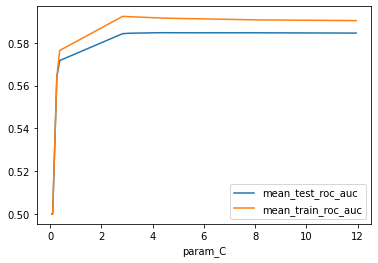

In [73]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")
search_time_start = time.time()
rcv.fit(df_train[x_columns], df_train[TARGET])
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

### Logistic Model With optimized Hyperparameters 

In [74]:
bst = LogisticRegression(penalty = 'l1', C=params['C'])

bst.fit(df_train[x_columns], df_train[TARGET])

ypred_train = bst.predict_proba(df_train[x_columns])[:, 1]
ypred_test = bst.predict_proba(df_test[x_columns])[:, 1]
df_model["GSPN_SCORE"] =  bst.predict_proba(df_model[x_columns])[:, 1]
print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(df_train[TARGET], ypred_train)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(df_test[TARGET], ypred_test)-1))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train GINI(COMBINED_SCORE) 0.178
Test GINI(COMBINED_SCORE) 0.075


### Save Model

In [75]:
pickle.dump(bst, open("gspn_model","wb"))
# bst =pickle.load(open(b"Fruits","rb"))

### Model Equation

In [76]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,COMBINED_SCORE_KNN_EXI,9.827534
1,RISK_FSTQPD30_RATE,1.328963
2,RISK_FPD30_RATE,4.563736
3,RISK_FSTPD30_RATE,1.216377


# Model Evaluation

### Check marginal Value add of Predictors

In [77]:
out = {'pred_list':[],'value':[]}

for y in range(len(x_columns)):
    tmp = {'pred':[],'value':[]}
    for x in x_columns:
        if x not in out['pred_list']:
            pred = out['pred_list'].copy()
            pred.append(x)
            bst = LogisticRegression(penalty = 'l1', C=params['C'], solver = 'liblinear')
            bst.fit(df_train[pred], df_train[TARGET])
            auc_cv = cross_val_score(bst, df_train[pred], df_train[TARGET], scoring='roc_auc', cv=3,n_jobs=-1)
            tmp["pred"].append(x)
            tmp["value"].append(2 * np.array(auc_cv).mean() - 1)
#             print("predictors :",pred,"Value :", 2 * np.array(auc_cv).mean() - 1)
    tmp_df = pd.DataFrame(tmp)
    out['pred_list'].append(tmp_df.loc[tmp_df["value"].idxmax(),"pred"])
    out['value'].append(tmp_df.loc[tmp_df["value"].idxmax(),"value"])    

In [78]:
out_df = pd.DataFrame(out)
out_df["increment"] = out_df.value-out_df.shift(1)["value"]
out_df

,pred_list,value,increment
0,COMBINED_SCORE_KNN_EXI,0.119043,NaN
1,RISK_FSTQPD30_RATE,0.145095,0.026052
2,RISK_FPD30_RATE,0.160357,0.015262
3,RISK_FSTPD30_RATE,0.169695,0.009338


### Check Proportion in Current GSPN

In [79]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

In [80]:
x = df_temp[OLD_GSPN_SCORE].value_counts()/len(df_temp)*100
x.sort_index()

1.0    39.945741
2.0    52.669019
3.0     7.385175
8.0     0.000065
Name: POS_GSPN_V2, dtype: float64

In [81]:
df_temp["GSPN_SCORE"].quantile([x[1]/100, (x[1]+x[2])/100])

0.399457    0.081193
0.926148    0.113907
Name: GSPN_SCORE, dtype: float64

### Define GSPN Clusters (Keeping Proportion Same as Current Setup)

In [82]:
df_model["GSPN_GROUP"]=np.where(df_model["GSPN_SCORE"]<df_temp["GSPN_SCORE"].quantile(x[1]/100), 1,np.where(df_model["GSPN_SCORE"]<df_temp["GSPN_SCORE"].quantile((x[1]+x[2])/100),2,3))

### WOE and IV comparison

In [83]:
def iv_df(df=None,target=None, cluster_num=None):
    data=df.copy()
    data['target1'] = data[target]
    data['target0'] = 1-data[target]
    data['bucket'] = data[cluster_num]
    grouped = data.groupby('bucket', as_index = True)
    liftstable  = pd.DataFrame(grouped.count()[target])
    liftstable.columns = ['total']
    liftstable['bads']   = round(grouped.sum()['target1'])
    liftstable['goods'] = round(grouped.sum()['target0'])
    liftstable['bad_rate'] = liftstable['bads']/liftstable['total']
    
    liftstable['%base'] = (liftstable.total / data['target1'].count())
    liftstable = liftstable.sort_index(ascending=True).reset_index(drop = False)
    liftstable.rename(columns = {'index':"CLUSTER"},inplace = True)
    liftstable['cum%_base'] = (liftstable.total / data['target1'].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data['target1'].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data['target1'].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()
    liftstable['woe'] = np.log(liftstable['%goods'] / liftstable['%bads'])
    liftstable = liftstable.replace({'woe': {np.inf: 0, -np.inf: 0}})
    liftstable['IV'] = (liftstable['%goods'] - liftstable['%bads']) * liftstable["woe"]
    
    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)
#     liftstable['bad_rate'] = liftstable['bad_rate'].apply('{0:.2%}'.format)

    pd.set_option('display.max_columns', 10)
    return(liftstable)

In [84]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

In [85]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model,target = TARGET, cluster_num = OLD_GSPN_SCORE)

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp[TARGET],df_temp[OLD_GSPN_SCORE])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]


IV Value:  0.018179449297943795
GINI Value:  6.62%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1.0,612083,25014.0,0.040867,34.38%,38.38%,0.110212,38.20%
1,2.0,807040,40249.0,0.049872,55.32%,50.13%,-0.098365,50.37%
2,3.0,113162,6991.0,0.061779,9.61%,6.94%,-0.325067,7.06%
3,8.0,1,0.0,0.000000,0.00%,0.00%,0.000000,0.00%


In [86]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model,target = TARGET, cluster_num = 'GSPN_GROUP')

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp[TARGET],df_temp['GSPN_GROUP'])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]

IV Value:  0.01941360898355772
GINI Value:  8.30%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1,624261,24166.0,0.038711,33.21%,39.23%,0.166647,38.96%
1,2,848991,40956.0,0.048241,56.29%,52.83%,-0.063387,52.99%
2,3,129020,7641.0,0.059223,10.50%,7.94%,-0.280105,8.05%


### MOM Gini (Aproved Base)

In [87]:
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

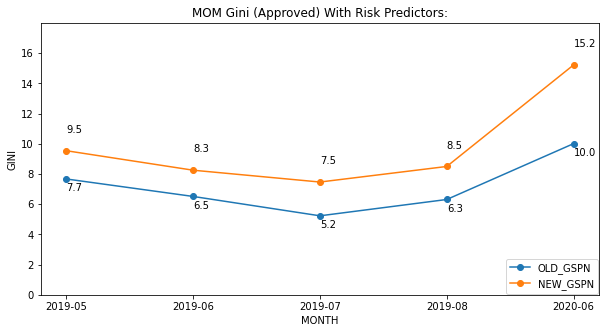

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,18)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,18,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
plt.show()

### MOM Gini (Phantomas Base)

In [89]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0  ]
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x][OLD_GSPN_SCORE])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_GROUP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

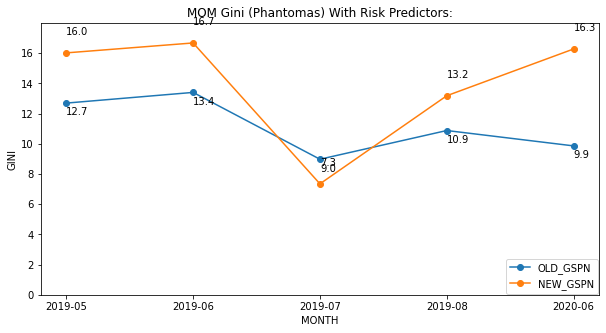

In [90]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,18)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,18,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors:")
plt.show()

### Population Distribution

In [91]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

In [92]:
df_temp.rename(columns = {OLD_GSPN_SCORE:"OLD_GSPN","GSPN_GROUP":"NEW_GSPN"}, inplace = True)

df_summ_old = pd.DataFrame(df_temp.groupby(["MONTH","OLD_GSPN"])["SKP_CREDIT_CASE"].count()).reset_index()
df_summ_old = df_summ_old.pivot("MONTH","OLD_GSPN","SKP_CREDIT_CASE")
df_summ_old.columns = ['OLD_GSPN_' + str(x) for x in df_summ_old.columns]

for x in df_summ_old.index:
    tmp = df_summ_old.loc[x,].sum()
    for y in df_summ_old.columns:
        df_summ_old.loc[x,y] = round(df_summ_old.loc[x,y]/tmp*100,1)

df_summ_new = pd.DataFrame(df_temp.groupby(["MONTH","NEW_GSPN"])["SKP_CREDIT_CASE"].count()).reset_index()
df_summ_new = df_summ_new.pivot("MONTH","NEW_GSPN","SKP_CREDIT_CASE")
df_summ_new.columns = ['NEW_GSPN_' + str(x) for x in df_summ_new.columns]

for x in df_summ_new.index:
    tmp = df_summ_new.loc[x,].sum()
    for y in df_summ_new.columns:
        df_summ_new.loc[x,y] = round(df_summ_new.loc[x,y]/tmp*100,1)

df_summ_all = df_summ_old.merge(df_summ_new, left_index = True, right_index = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


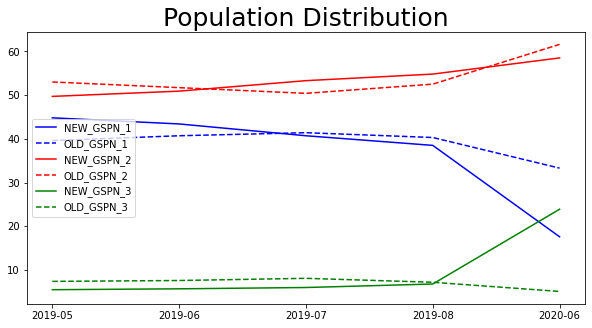

In [93]:
plt.figure(figsize=(10,5))
plt.plot(df_summ_new["NEW_GSPN_1"], color = 'b',label="NEW_GSPN_1")
plt.plot(df_summ_old["OLD_GSPN_1.0"],linestyle='--', color = 'b',label="OLD_GSPN_1")

plt.plot(df_summ_new["NEW_GSPN_2"], color = 'r',label="NEW_GSPN_2")
plt.plot(df_summ_old["OLD_GSPN_2.0"],linestyle='--', color = 'r',label="OLD_GSPN_2")

plt.plot(df_summ_new["NEW_GSPN_3"], color = 'g',label="NEW_GSPN_3")
plt.plot(df_summ_old["OLD_GSPN_3.0"],linestyle='--', color = 'g',label="OLD_GSPN_3")

plt.title('Population Distribution',fontsize=25)
plt.legend()

### Deinquency Rate

In [94]:
df_summ_old = pd.DataFrame(df_temp.groupby(["MONTH","OLD_GSPN"])[TARGET,AGRF_FLAG].sum()).reset_index()
df_summ_old[TARGET+"_%"] = round(df_summ_old[TARGET]/df_summ_old[AGRF_FLAG],3)
df_summ_old = df_summ_old.pivot("MONTH","OLD_GSPN",TARGET+"_%")
df_summ_old.columns = ['OLD_GSPN_' + str(x) for x in df_summ_old.columns]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [95]:
df_summ_new = pd.DataFrame(df_temp.groupby(["MONTH","NEW_GSPN"])[TARGET,AGRF_FLAG].sum()).reset_index()
df_summ_new[TARGET+"_%"] = round(df_summ_new[TARGET]/df_summ_new[AGRF_FLAG],3)
df_summ_new = df_summ_new.pivot("MONTH","NEW_GSPN",TARGET+"_%")
df_summ_new.columns = ['NEW_GSPN_' + str(x) for x in df_summ_new.columns]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [96]:
df_summ_all = df_summ_old.merge(df_summ_new, left_index = True, right_index = True)

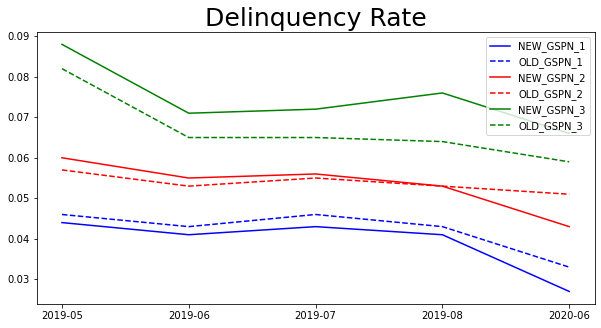

In [97]:
plt.figure(figsize=(10,5))
plt.plot(df_summ_new["NEW_GSPN_1"], color = 'b',label="NEW_GSPN_1")
plt.plot(df_summ_old["OLD_GSPN_1.0"],linestyle='--', color = 'b',label="OLD_GSPN_1")

plt.plot(df_summ_new["NEW_GSPN_2"], color = 'r',label="NEW_GSPN_2")
plt.plot(df_summ_old["OLD_GSPN_2.0"],linestyle='--', color = 'r',label="OLD_GSPN_2")

plt.plot(df_summ_new["NEW_GSPN_3"], color = 'g',label="NEW_GSPN_3")
plt.plot(df_summ_old["OLD_GSPN_3.0"],linestyle='--', color = 'g',label="OLD_GSPN_3")

plt.title('Delinquency Rate',fontsize=25)
plt.legend()

### MOM Predictor value trend

In [108]:
df_summ = df_temp.groupby('MONTH')[x_columns].mean()

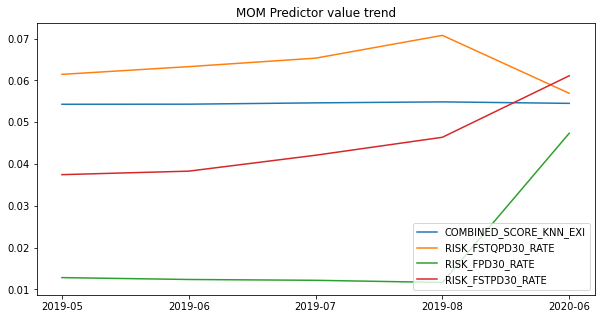

In [114]:
plt.figure(figsize=(10,5))

for x in (x_columns):
    plt.plot(df_summ[x], label=x)

plt.title('MOM Predictor value trend')
plt.legend()

### Shift Analysis

In [98]:
df_summ = df_temp.groupby(["OLD_GSPN","NEW_GSPN"])["SKP_CREDIT_CASE"].count().reset_index()

print("TOTAL CASE COUNT")
df_summ.pivot(index="OLD_GSPN",columns = "NEW_GSPN", values="SKP_CREDIT_CASE")

TOTAL CASE COUNT


NEW_GSPN,1,2,3
OLD_GSPN,,,
1.0,404773.0,201924.0,5386.0
2.0,195745.0,540609.0,70686.0
3.0,11522.0,64507.0,37133.0
8.0,NaN,1.0,NaN


In [99]:
df_summ["CASE_%"] = round(df_summ["SKP_CREDIT_CASE"]/(df_summ["SKP_CREDIT_CASE"].sum())*100,0)

print("% Cases")
df_summ.pivot(index="OLD_GSPN",columns = "NEW_GSPN", values="CASE_%")

% Cases


NEW_GSPN,1,2,3
OLD_GSPN,,,
1.0,26.0,13.0,0.0
2.0,13.0,35.0,5.0
3.0,1.0,4.0,2.0
8.0,NaN,0.0,NaN


In [100]:
df_summ = df_temp.groupby(["OLD_GSPN","NEW_GSPN"])[[AGRF_FLAG,TARGET]].sum().reset_index()

df_summ[TARGET+"_%"] = round(df_summ[TARGET]/df_summ[AGRF_FLAG]*100,2)

print(TARGET+"_%")
df_summ.pivot(index="OLD_GSPN",columns = "NEW_GSPN", values=TARGET+"_%")

RISK_FSTQPD60_%


NEW_GSPN,1,2,3
OLD_GSPN,,,
1.0,4.03,4.99,5.01
2.0,4.50,5.51,7.24
3.0,4.90,6.50,8.05
8.0,NaN,0.00,NaN


# Define Cutoffs Based on WOE

In [101]:
import sys
sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Scoring Workflow")

In [102]:
from scoring.grouping import Grouping

grouping = Grouping(columns = ["GSPN_SCORE"],
                    cat_columns = [],
                    group_count=3, 
                    min_samples=1000, 
                    min_samples_cat=1000)

train_mask =  pd.Series(data =np.where((df_model.TIME_CREATION_DATE >= pd.datetime(2019,1,1))& (df_model.TIME_CREATION_DATE <= pd.datetime(2019,6,30)),True,False),index=df_model.index) 

grouping.fit(df_model[train_mask][["GSPN_SCORE"]],
             df_model[train_mask][TARGET],
#             w=df_model[train_mask],
            progress_bar=True, category_limit=10000);

model_filename = 'myGrouping'
grouping.save(model_filename)

df_model["GSPN_WOE"] = grouping.transform(df_model[["GSPN_SCORE"]], transform_to='woe', progress_bar=True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


'Grouping saved on 2020-12-17 16:50:21 to file myGrouping'

***

### GSPN_SCORE

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_GSPN_SCORE,,,,,,,,
"[-inf, 0.08665)",441450.0,18654.0,0.0423,0.5473,0.6276,0.1341,0.1369,0.6237
"[0.08665, 0.1231)",240952.0,13463.0,0.0559,0.3950,0.3377,-0.1540,-0.1568,0.3404
"[0.1231, inf)",25387.0,1968.0,0.0775,0.0577,0.0348,-0.4996,-0.5074,0.0359
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.9839,0.0000


IV: 0.0316
Gini: 8.61


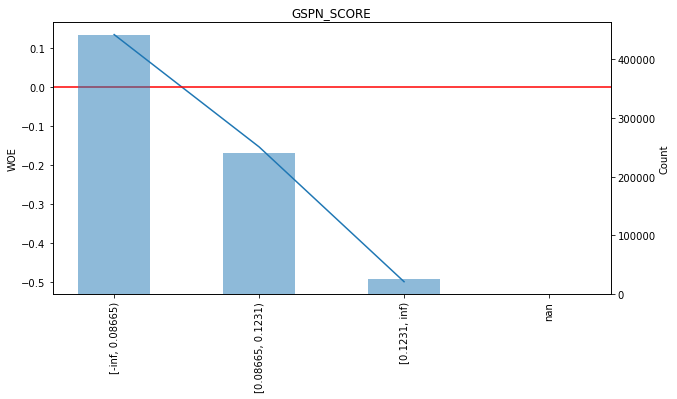

In [103]:
grouping.plot_bins(data=df_model[["GSPN_SCORE",TARGET]], cols_pred_num=['GSPN_SCORE'], cols_pred_cat=[],
                    mask=train_mask, col_target=TARGET, output_folder=os.getcwd(), col_weight=None)

In [104]:
df_model["GSPN_GROUP"]=np.where(df_model["GSPN_SCORE"]<0.07335, 1,np.where(df_model["GSPN_SCORE"]<0.09355,2,3))

In [105]:
df_temp = df_model.dropna(subset = [OLD_GSPN_SCORE])

In [106]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model[train_mask],target = TARGET, cluster_num = OLD_GSPN_SCORE)

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp[TARGET],df_temp[OLD_GSPN_SCORE])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]


IV Value:  0.020267720284858712
GINI Value:  6.62%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1.0,284207,11792.0,0.041491,34.60%,40.44%,0.155972,40.15%
1,2.0,370504,18800.0,0.050742,55.16%,52.20%,-0.055000,52.35%
2,3.0,52904,3482.0,0.065817,10.22%,7.34%,-0.331145,7.47%


In [107]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model[train_mask],target = TARGET, cluster_num = 'GSPN_GROUP')

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp[TARGET],df_temp["GSPN_GROUP"])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]

IV Value:  0.027164520971234778
GINI Value:  7.85%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1,107973,3949.0,0.036574,11.59%,15.44%,0.287226,15.25%
1,2,445187,20706.0,0.046511,60.75%,63.01%,0.036510,62.90%
2,3,154629,9430.0,0.060985,27.67%,21.55%,-0.249724,21.85%
